# 0. Environment Setup

In [1]:
import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger().setLevel(level=logging.ERROR)

import warnings
warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 14

# 1. Load the data

In [4]:
import pandas as pd

data = pd.read_csv('S-1.csv')
data.shape

(10149, 2)

In [5]:
data.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


# 2. Visualize the raw data

In [6]:
def plot(data, anomalies=None):
    data.plot(x='timestamp', y='value', alpha=0.5)
    if anomalies is not None:
        for _, anom in anomalies.iterrows():
            plt.axvspan(anom.start, anom.end, facecolor='#2ca02c', alpha=0.5)

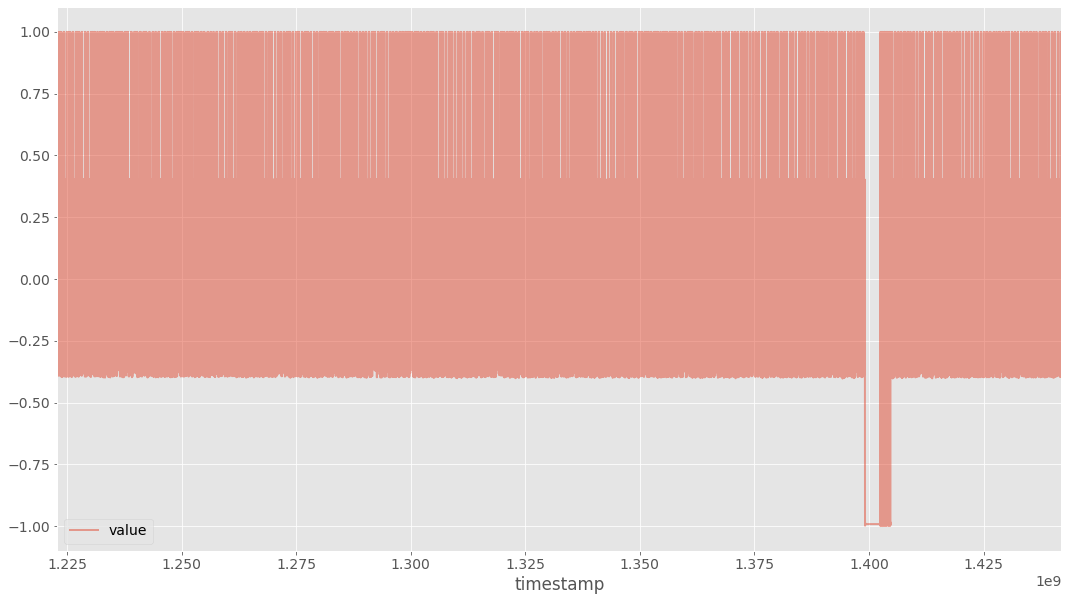

In [7]:
import pandas as pd

plot(data)

# 3. Build the Pipeline

In [8]:
pipeline_dict = {
    "primitives": [
        "mlprimitives.custom.timeseries_preprocessing.time_segments_average",
        "sklearn.impute.SimpleImputer",
        "sklearn.preprocessing.MinMaxScaler",
        "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences",
        "keras.Sequential.LSTMTimeSeriesRegressor",
        "mlprimitives.custom.timeseries_anomalies.regression_errors",
        "mlprimitives.custom.timeseries_anomalies.find_anomalies"
    ],
    "init_params": {
        "mlprimitives.custom.timeseries_preprocessing.time_segments_average#1": {
            "time_column": "timestamp",
            "interval": 21600
        },
        "sklearn.preprocessing.MinMaxScaler#1": {
            "feature_range": [
                -1,
                1
            ]
        },
        "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
            "target_column": 0,
            "window_size": 300
        },
        "keras.Sequential.LSTMTimeSeriesRegressor": {
            "epochs": 1,
            "verbose": True,
            "input_shape": [
                300,
                1
            ]
        }
    },
    "input_names": {
        "mlprimitives.custom.timeseries_anomalies.find_anomalies#1": {
            "index": "target_index"
        }
    },
    "output_names": {
        "keras.Sequential.LSTMTimeSeriesRegressor#1": {
            "y": "y_hat"
        }
    }
}

In [22]:
from mlblocks import MLPipeline

pipeline = MLPipeline(pipeline_dict)

# 4. Fit

In [10]:
pipeline.fit(data)

Using TensorFlow backend.


Train on 7879 samples, validate on 1970 samples
Epoch 1/1
9849/9849 [==============================] - 12s 1ms/step


# 5. Save to a file

In [12]:
import pickle

with open('pipeline.pkl', 'wb') as pickle_dump_file:
    pickle.dump(pipeline, pickle_dump_file)

# 6. Load from a file

In [16]:
with open('pipeline.pkl', 'rb') as pickle_load_file:
    loaded = pickle.load(pickle_load_file)

# 7. Make predictions

In [17]:
anomalies = loaded.predict(data)

9849/9849 [==============================] - 12s 1ms/step


In [18]:
anomalies

array([[1.39888080e+09, 1.40644080e+09, 4.94193091e-01]])

In [19]:
anomalies = pd.DataFrame(anomalies, columns=['start', 'end', 'score'])

In [20]:
anomalies

,start,end,score
0,1.398881e+09,1.406441e+09,0.494193


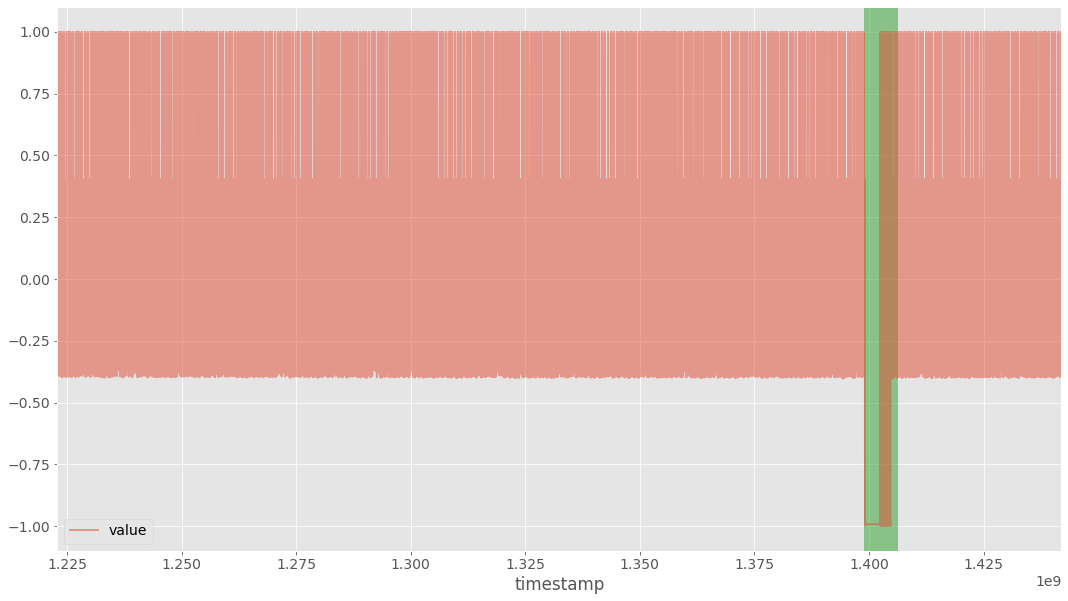

In [21]:
plot(data, anomalies)